In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

time_epoch = 60
epochs_per_batch = 20

# hard coded nrows
df_all = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=100000)

df_all.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

df = df_all[df_all['time'] <= epochs_per_batch * time_epoch]

df.index = df['time']
df.drop(columns=['time'],inplace=True)
df.head()

c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
1,0,C1065,389,C3799,N10451,6,10,5323
1,0,C1423,N1136,C1707,N1,6,5,847
1,0,C1423,N1142,C1707,N1,6,5,847
1,0,C14909,N8191,C5720,2049,6,1,52
1,0,C14909,N8192,C5720,2049,6,1,52


In [2]:
# get all the host in the buckets we are interested in 

hosts = np.array(list(set(df_all[df_all['time'] <= epochs_per_batch * time_epoch * 2]['source computer'].values))) 

In [3]:
from helper import group_scale_data, group_scale_data_batch

groupped_data, hosts, parameters = group_scale_data(df, size_of_bin_seconds=time_epoch,
                                                    doScale=True, scaler='log', hosts=hosts)

In [4]:
groupped_data.head()

,number of flows,mean(byte count),epoch,source computer
0,40,27,1,C1015
19283,1,1,1,C4581
11304,1,1,1,C184
11287,1,1,1,C831
23236,1,1,1,C5018


In [5]:
df1 = df_all[(df_all['time'] > epochs_per_batch * time_epoch) & (df_all['time'] <= epochs_per_batch * time_epoch * 2)]

df1.index = df1['time']
df1.drop(columns=['time'], inplace=True)
df1.head()

c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
1201,0,C17,N813,C1883,445,6,1,52
1201,0,C1883,445,C17,N813,6,1,46
1201,0,C5721,445,C51,N1057,6,1,168
1201,1,C51,N1057,C5721,445,6,2,178
1201,10,C2001,N9552,C1707,N1,6,9,2929


In [6]:
# TODO what to do with new hosts or hosts that dont have values in the second batch ?

groupped_data1, hosts1 = group_scale_data_batch(df1, parameters)

In [7]:
# HARD CODED TODO ADD TO FUNCTION

groupped_data1['epoch'] += epochs_per_batch

In [8]:
groupped_data1.head()

,number of flows,mean(byte count),epoch,source computer
0,12,49,21,C1000
12419,1,1,21,C2496
25982,1,1,21,C6
12435,1,1,21,C812
25965,1,1,21,C2303


In [9]:
assert len(groupped_data) == len(groupped_data1)

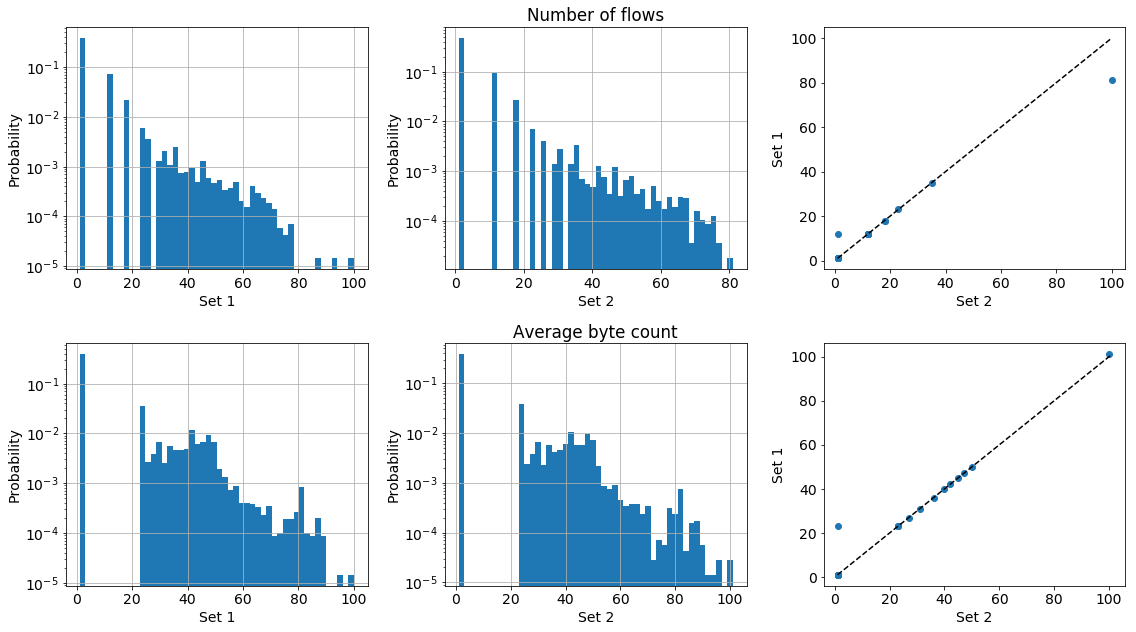

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 16, 9
rcParams['font.size'] = 14

def plot_qq_plot(data1, data2, i, N, label):
    plt.subplot(N, 3, i * 3 - 2)
    # the histogram of the data
    plt.hist(data1, 50, normed=1, log=True)
    plt.grid(True)
    plt.ylabel('Probability')
    plt.xlabel('Set 1')
    
    plt.subplot(N, 3, i * 3 - 1)
    # the histogram of the data
    plt.title(label)
    plt.hist(data2, 50, normed=1, log=True)
    plt.grid(True)
    plt.ylabel('Probability')
    plt.xlabel('Set 2')
    
    plt.subplot(N, 3, i * 3)
    plt.ylabel('Set 1')
    plt.xlabel('Set 2')
    
    percs = np.linspace(0,100,51)
    qn_a = np.percentile(data1, percs)
    qn_b = np.percentile(data2, percs)

    plt.plot(qn_a,qn_b, ls="", marker="o")

    x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
    plt.plot(x,x, color="k", ls="--")

plot_qq_plot(groupped_data['number of flows'].values, groupped_data1['number of flows'].values, 1, 2, 'Number of flows')
plot_qq_plot(groupped_data['mean(byte count)'].values, groupped_data1['mean(byte count)'].values, 2, 2, 'Average byte count')

plt.tight_layout()

plt.show()

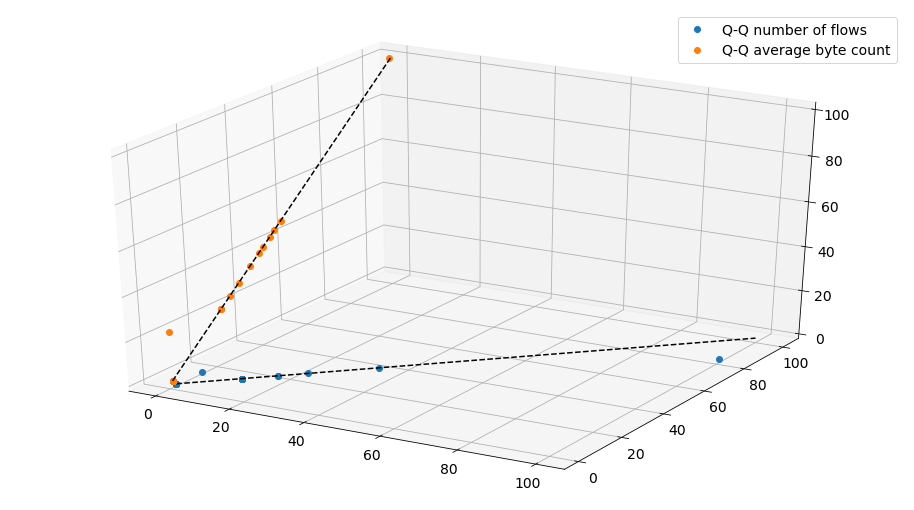

In [11]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 16, 9

percs = np.linspace(0,100,51)

fig = plt.figure()
ax = fig.gca(projection='3d')


qn_flows_a = np.percentile(groupped_data['number of flows'].values, percs)
qn_flows_b = np.percentile(groupped_data1['number of flows'].values, percs)

z = np.zeros(len(percs))
ax.plot(qn_flows_a, qn_flows_b, z, label='Q-Q number of flows', ls="", marker="o")

x = np.linspace(np.min((qn_flows_a.min(),qn_flows_b.min())), np.max((qn_flows_a.max(),qn_flows_b.max())))
ax.plot(x, x, np.zeros(len(x)), color="k", ls="--")


qn_mean_bytes_a = np.percentile(groupped_data['mean(byte count)'].values, percs)
qn_mean_bytes_b = np.percentile(groupped_data1['mean(byte count)'].values, percs)

z = np.zeros(len(percs))

ax.plot(z, qn_mean_bytes_a, qn_mean_bytes_b, label='Q-Q average byte count', ls="", marker="o")

x = np.linspace(np.min((qn_mean_bytes_a.min(),qn_mean_bytes_b.min())), np.max((qn_mean_bytes_a.max(),qn_mean_bytes_b.max())))
plt.plot(np.zeros(len(x)), x, x, color="k", ls="--")





ax.legend()

plt.show()


In [12]:
np.percentile(groupped_data['number of flows'].values, percs)

array([   1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,   12.,   12.,   12.,   12.,   12.,   12.,
         12.,   18.,   18.,   23.,   35.,  100.])

In [13]:
np.percentile(groupped_data1['number of flows'].values, percs)

array([  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,  12.,  12.,  12.,  12.,  12.,  12.,
        12.,  12.,  18.,  18.,  23.,  35.,  81.])